In [1]:
# Imports 
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from transformers import BertModel, BertTokenizer, BertConfig, DistilBertConfig, TFDistilBertModel
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from keras import backend as K
import matplotlib.pyplot as plt 

In [2]:
# Import data
data = pd.read_csv("../../data/mturk_experiment_2.csv",encoding='unicode_escape')
labels = data["Formality"]
samples = data["Sentence"]

# Testing with 90% training data
train_samples, test_samples, train_labels,test_labels = train_test_split(samples, labels, test_size=0.1)

train_samples = np.array(train_samples)
test_samples = np.array(test_samples)
train_labels = np.array(train_labels)
test_labels = np.array(test_labels)

In [3]:
# Attention layer
class peel_the_layer(tf.keras.layers.Layer): 

    def __init__(self):    
        ##Nothing special to be done here
        super(peel_the_layer, self).__init__()

    def build(self, input_shape):
        ##Define the shape of the weights and bias in this layer
        ##This is a 1 unit layer. 
        units=1
        ##last index of the input_shape is the number of dimensions of the prev
        ##RNN layer. last but 1 index is the num of timesteps
        self.w=self.add_weight(name="att_weights", shape=(input_shape[-1], units), initializer="normal") #name property is useful for avoiding RuntimeError: Unable to create link.
        self.b=self.add_weight(name="att_bias", shape=(input_shape[-2], units), initializer="zeros")
        super(peel_the_layer,self).build(input_shape)

    def call(self, x):
        ##x is the input tensor..each word that needs to be attended to
        ##Below is the main processing done during training
        ##K is the Keras Backend import
        e = K.tanh(K.dot(x,self.w)+self.b)
        a = K.softmax(e, axis=1)
        output = x*a

        ##return the ouputs. 'a' is the set of attention weights
        ##the second variable is the 'attention adjusted o/p state' or context
        return a, K.sum(output, axis=1)



In [1]:
bert_model_name = 'small_bert/bert_en_uncased_L-4_H-512_A-8' 

tfhub_handle_encoder = 'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3'
tfhub_handle_preprocess =   'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3'
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)
bert_model = hub.KerasLayer(tfhub_handle_encoder)

NameError: name 'hub' is not defined

In [5]:
text_test = ['this is such an amazing movie!']
bert_results = bert_model(bert_preprocess_model(text_test))

In [6]:
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
encoder_inputs = preprocessing_layer(text_input)
encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
outputs = encoder(encoder_inputs)
net = outputs['pooled_output']
reshaped = tf.reshape(net,[-1, 768, 1])
lstm = tf.keras.layers.LSTM(512,return_sequences=True)(reshaped)
a, context = peel_the_layer()(lstm)

dense = tf.keras.layers.Dense(1)(context)
model = tf.keras.Model(text_input, dense)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text (InputLayer)               [(None,)]            0                                            
__________________________________________________________________________________________________
preprocessing (KerasLayer)      {'input_word_ids': ( 0           text[0][0]                       
__________________________________________________________________________________________________
BERT_encoder (KerasLayer)       {'pooled_output': (N 108310273   preprocessing[0][0]              
                                                                 preprocessing[0][1]              
                                                                 preprocessing[0][2]              
______________________________________________________________________________________________

In [7]:
loss = 'mse'
metrics = tf.keras.metrics.MeanSquaredError()
optimiser = tf.optimizers.Adam(learning_rate= 5e-5)

In [8]:
model.compile(optimizer=optimiser, loss=loss, metrics=metrics)

In [9]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

#90% training data - 10 epochs
history = model.fit(x=train_samples,y=train_labels,batch_size=32,epochs=10,verbose=2,callbacks=[callback])

Epoch 1/10
198/198 - 3357s - loss: 3.2386 - mean_squared_error: 3.2386
Epoch 2/10
198/198 - 3501s - loss: 0.4049 - mean_squared_error: 0.4049
Epoch 3/10
198/198 - 3489s - loss: 0.2356 - mean_squared_error: 0.2356
Epoch 4/10
198/198 - 3425s - loss: 0.1229 - mean_squared_error: 0.1229
Epoch 5/10
198/198 - 3495s - loss: 0.0778 - mean_squared_error: 0.0778
Epoch 6/10
198/198 - 3482s - loss: 0.0532 - mean_squared_error: 0.0532
Epoch 7/10
198/198 - 3481s - loss: 0.0428 - mean_squared_error: 0.0428
Epoch 8/10
198/198 - 4340s - loss: 0.0341 - mean_squared_error: 0.0341
Epoch 9/10
198/198 - 4253s - loss: 0.0310 - mean_squared_error: 0.0310
Epoch 10/10
198/198 - 4072s - loss: 0.0277 - mean_squared_error: 0.0277


In [10]:
scores = model.evaluate(x=test_samples,y=test_labels)
scores

22/22 [==============================] - 119s 5s/step - loss: 0.5469 - mean_squared_error: 0.5469


[0.5468968749046326, 0.5468968749046326]

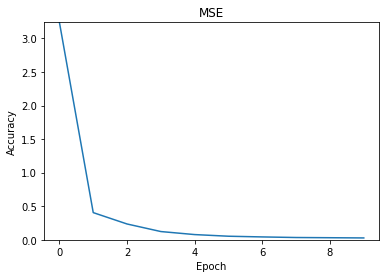

In [11]:
plt.plot(history.history['loss'])
plt.title('MSE')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')


ymax = max(history.history['loss'])
plt.ylim(top=ymax)
plt.ylim(bottom=0)
plt.show()